In [1]:
%load_ext autoreload
%autoreload 2

import torch
torch.autograd.set_detect_anomaly(True)

from src.models.gnnprocessor import GNNProcessor
from src.visualization.visualize import visualize_graph
from src.models.train_model import HydraulicsLoss

from torch_geometric.nn import summary
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt

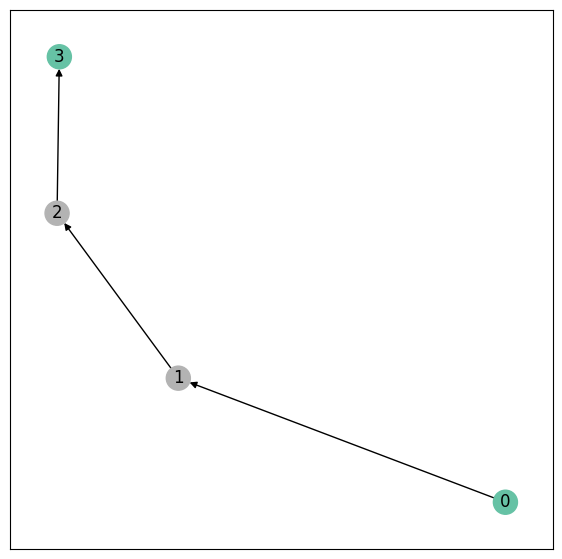

In [2]:
# Пример 1
edge_index = torch.tensor([
  [0, 1, 2],
  [1, 2, 3]
], dtype=torch.long)

# Структура данных атрибутов вершин графа:
# Расход газа потребителя в узле, млн м3/сут; Давление газа, МПа
x = torch.tensor([[0, 7.4], [0.5, 0], [0, 0], [0, 5.4]], dtype=torch.float)

# Структура данных атрибутов дуг графа:
# Протяженность, км; Внутренний диаметр трубы, мм
edge_attr = torch.tensor([
  [38, 1400],
  [40, 1400],
  [43, 1400]
])

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

G = to_networkx(data, to_undirected=False)
visualize_graph(G, color=data.x[..., 1] == 0);

## Пример 2
# edge_index = torch.tensor([
#   [0, 1],
#   [1, 2]
# ], dtype=torch.long)

# # Структура данных атрибутов вершин графа:
# # Расход газа потребителя в узле, млн м3/сут; Давление газа, МПа
# x = torch.tensor([[0, 7.4], [0, 0], [0, 5.4]], dtype=torch.float)

# # Структура данных атрибутов дуг графа:
# # Протяженность, км; Внутренний диаметр трубы, мм
# edge_attr = torch.tensor([
#   [55, 1400],
#   [60, 1400]])

# data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# G = to_networkx(data, to_undirected=False)
# visualize_graph(G, color=data.x[..., 1] == 0);

## Пример 3
# edge_index = torch.tensor([
#   [0, 1, 3, 2],
#   [1, 2, 1, 4]
# ], dtype=torch.long)

# # Структура данных атрибутов вершин графа:
# # Расход газа потребителя в узле, млн м3/сут; Давление газа, МПа
# x = torch.tensor([[0, 7.4], [0.0, 0], [0, 0.0], [0, 7.0], [0, 5.4]], dtype=torch.float)

# # Структура данных атрибутов дуг графа:
# # Протяженность, км; Внутренний диаметр трубы, мм
# edge_attr = torch.tensor([
#   [38, 1400],
#   [40, 1400],
#   [43, 1400],
#   [50, 1200]
# ])

# data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# G = to_networkx(data, to_undirected=False)
# visualize_graph(G, color=data.x[..., 1] == 0);

In [3]:
model = GNNProcessor(out_channels=1, num_edge_features=data.num_edge_features, latent_dim=10, num_convs=20)

print(model)

GNNProcessor(
  (convs): ModuleList(
    (0-19): 20 x GNNSConv(aggr=mean, latent_dim=10)
  )
  (final): Linear(in_features=10, out_features=1, bias=True)
  (balance_conv): BalanceConv()
)


In [4]:
print(summary(model, data=data, max_depth=5))

+-----------------------------+---------------------------------+------------------------+----------+
| Layer                       | Input Shape                     | Output Shape           | #Param   |
|-----------------------------+---------------------------------+------------------------+----------|
| GNNProcessor                |                                 | [4, 1], [4, 1], [4, 1] | 38,531   |
| ├─(convs)ModuleList         | --                              | --                     | 38,520   |
| │    └─(0)GNNSConv          | [4, 10], [2, 3], [4, 2], [3, 2] | [4, 10]                | 1,926    |
| │    └─(1)GNNSConv          | [4, 10], [2, 3], [4, 2], [3, 2] | [4, 10]                | 1,926    |
| │    └─(2)GNNSConv          | [4, 10], [2, 3], [4, 2], [3, 2] | [4, 10]                | 1,926    |
| │    └─(3)GNNSConv          | [4, 10], [2, 3], [4, 2], [3, 2] | [4, 10]                | 1,926    |
| │    └─(4)GNNSConv          | [4, 10], [2, 3], [4, 2], [3, 2] | [4, 10]         

In [5]:
# Test
P, flows, imbalance = model(data)
print(f'{P=}')
print(f'{flows=}')
print(f'{imbalance=}')
print(f'loss = {HydraulicsLoss()(data, P, imbalance)}')

P=tensor([[0.1202],
        [0.0000],
        [0.0000],
        [0.3175]], grad_fn=<ReluBackward0>)
flows=tensor([[   0.0000],
        [ 243.1919],
        [   0.0000],
        [-166.8280]], grad_fn=<ScatterAddBackward0>)
imbalance=tensor([[-243.1919],
        [ 243.1919],
        [ 166.8280],
        [-166.8280]], grad_fn=<SubBackward0>)
loss = 43486.95703125


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
data.to(device)
criterion = HydraulicsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

losses = []
def train():
  model.train()
  optimizer.zero_grad()
  P, _, imbalance = model(data)
  loss = criterion(data, P, imbalance)
  losses.append(loss.item())
  loss.backward()

  # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.01)  

  optimizer.step()
  return loss

for epoch in range(150):
  loss = train()
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')  

Epoch: 000, Loss: 763.7169
Epoch: 001, Loss: 32687.3477
Epoch: 002, Loss: 40.6002
Epoch: 003, Loss: 13498.8369
Epoch: 004, Loss: 13259.8115
Epoch: 005, Loss: 8109.0845
Epoch: 006, Loss: 1550.4363
Epoch: 007, Loss: 1069.9712
Epoch: 008, Loss: 7005.9834
Epoch: 009, Loss: 1563.4089
Epoch: 010, Loss: 1759.7581
Epoch: 011, Loss: 2427.8347
Epoch: 012, Loss: 3108.2136
Epoch: 013, Loss: 3572.6953
Epoch: 014, Loss: 3701.4724
Epoch: 015, Loss: 3457.4536
Epoch: 016, Loss: 2936.2979
Epoch: 017, Loss: 2286.7034
Epoch: 018, Loss: 1651.6056
Epoch: 019, Loss: 1168.2029
Epoch: 020, Loss: 1091.0182
Epoch: 021, Loss: 1554.8022
Epoch: 022, Loss: 1619.6613
Epoch: 023, Loss: 879.9949
Epoch: 024, Loss: 413.1531
Epoch: 025, Loss: 326.5898
Epoch: 026, Loss: 451.0497
Epoch: 027, Loss: 594.9512
Epoch: 028, Loss: 588.1903
Epoch: 029, Loss: 397.1089
Epoch: 030, Loss: 139.6807
Epoch: 031, Loss: 29.4803
Epoch: 032, Loss: 197.1564
Epoch: 033, Loss: 402.9309
Epoch: 034, Loss: 339.0672
Epoch: 035, Loss: 120.0899
Epoch:

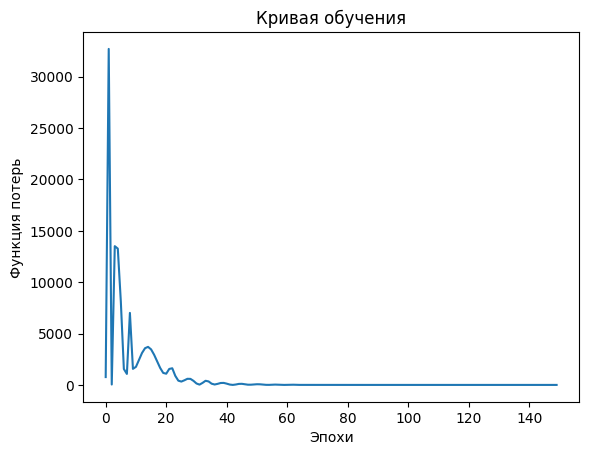

In [10]:
plt.plot(losses)
plt.title('Кривая обучения')
plt.xlabel('Эпохи')
plt.ylabel('Функция потерь')
plt.show()

In [11]:
%%time
# %%timeit 

# Attention: При выводе значений давления краевые значения не выводятся, но учитываются в расчете
P, flows, imbalance = model(data)
print(f'{P=}')
print(f'{flows=}')
print(f'{imbalance=}')

P=tensor([[5.3583],
        [6.8354],
        [6.1857],
        [5.4998]], grad_fn=<ReluBackward0>)
flows=tensor([[ 0.0000],
        [93.1657],
        [93.1738],
        [93.2076]], grad_fn=<ScatterAddBackward0>)
imbalance=tensor([[-9.3166e+01],
        [-8.1024e-03],
        [-3.3813e-02],
        [ 9.3208e+01]], grad_fn=<SubBackward0>)
CPU times: user 152 ms, sys: 11.9 ms, total: 164 ms
Wall time: 163 ms


# Анализ